### Import Libraries

In [1]:
import cupy as cp  # cupy é o "numpy" do RAPIDS
import cudf        # cudf é o "pandas" do RAPIDS
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from cuml.preprocessing import StandardScaler, LabelEncoder
from cuml.model_selection import StratifiedKFold
from cuml.pipeline import Pipeline
from cuml.neighbors import KNeighborsClassifier
from cuml.svm import SVC
from cuml.ensemble import RandomForestClassifier
from cuml.metrics import accuracy_score
from cuml.metrics import confusion_matrix

import utils

### Audio Preprocessing

In [ ]:
# 1. Carregar os dados oficiais
# Certifique-se de que o utils.py do mdeff/fma esteja no seu diretório
METADATA_DIR = '../fma_metadata' 
tracks = utils.load(f'{METADATA_DIR}/tracks.csv')
features = utils.load(f'{METADATA_DIR}/features.csv')

# 2. Filtrar pelo dataset 'small'
small_mask = tracks[('set', 'subset')] == 'small'

X_all = features.loc[small_mask]
y_all_labels = tracks.loc[small_mask, ('track', 'genre_top')]
splits = tracks.loc[small_mask, ('set', 'split')]

y_all_labels = y_all_labels.astype(str)

print(f"Total de faixas 'fma_small': {X_all.shape[0]}")
print(f"Total de features: {X_all.shape[1]}")

# 3. Codificar os Gêneros (Labels)
label_encoder = LabelEncoder()
y_all_encoded = label_encoder.fit_transform(y_all_labels)

X_all = cudf.DataFrame(X_all)
y_all_encoded = cudf.Series(y_all_encoded)

y_all_encoded = y_all_encoded.astype('int32')

Total de faixas 'fma_small': 8000
Total de features: 518


### Treino dos Modelos


Iniciando CV 10-Fold para KNN (GPU)...

Iniciando CV 10-Fold para SVM (GPU)...

Iniciando CV 10-Fold para Random Forest (GPU)...

--- Treinamento e Avaliação de CV Concluídos ---

========= Resultados KNN (10-Fold CV) =========
--- Acurácia ---
  Média        : 0.4822
  Desv. Padrão : 0.0223
--- Precisão (Macro) ---
  Média        : 0.4922
  Desv. Padrão : 0.0223
--- Recall (Macro) ---
  Média        : 0.4822
  Desv. Padrão : 0.0223
--- F1-Score (Macro) ---
  Média        : 0.4740
  Desv. Padrão : 0.0225

========= Resultados SVM (10-Fold CV) =========
--- Acurácia ---
  Média        : 0.6179
  Desv. Padrão : 0.0114
--- Precisão (Macro) ---
  Média        : 0.6199
  Desv. Padrão : 0.0122
--- Recall (Macro) ---
  Média        : 0.6179
  Desv. Padrão : 0.0114
--- F1-Score (Macro) ---
  Média        : 0.6175
  Desv. Padrão : 0.0119

========= Resultados Random Forest (10-Fold CV) =========
--- Acurácia ---
  Média        : 0.5649
  Desv. Padrão : 0.0087
--- Precisão (Macro) ---
  Média  

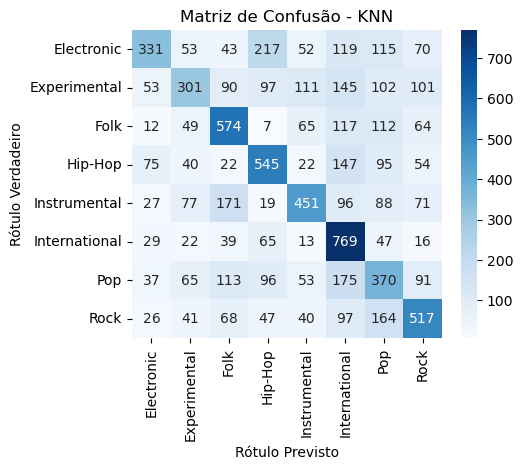

--- SVM ---


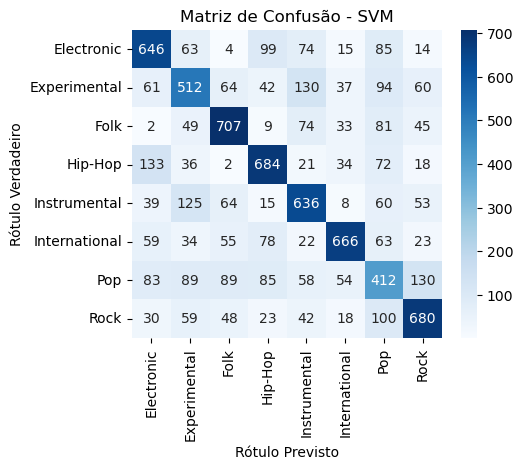

--- Random Forest ---


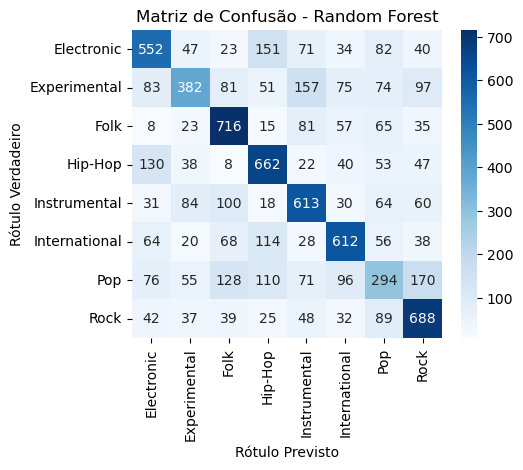

In [ ]:
def calculate_metrics_from_confusion_matrix(cm):
    """
    Calcula Precisão, Recall e F1 (macro) a partir de uma matriz de confusão cupy.
    """
    # Evitar divisão por zero (adiciona um valor muito pequeno onde a soma é 0)
    epsilon = 1e-9
    
    # 1. True Positives (TP): A diagonal
    tp = cp.diag(cm)
    
    # 2. False Positives (FP): Soma da coluna - TP
    fp = cp.sum(cm, axis=0) - tp
    
    # 3. False Negatives (FN): Soma da linha - TP
    fn = cp.sum(cm, axis=1) - tp
    
    # 4. Calcular métricas por classe
    precision_per_class = tp / (tp + fp + epsilon)
    recall_per_class = tp / (tp + fn + epsilon)
    f1_per_class = 2 * (precision_per_class * recall_per_class) / (precision_per_class + recall_per_class + epsilon)
    
    # 5. Calcular a média "macro"
    macro_precision = cp.mean(precision_per_class)
    macro_recall = cp.mean(recall_per_class)
    macro_f1 = cp.mean(f1_per_class)
    
    return macro_precision, macro_recall, macro_f1

# 4. Definir a Estratégia de CV
# Usar StratifiedKFold é ideal para classificação, pois mantém
# a proporção de classes em cada fold (o fma_small é balanceado,
# mas esta é uma boa prática).
n_splits = 10
kf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

# 5. Criar Pipelines para os Modelos
# Isso garante que o StandardScaler seja "fitado" apenas nos dados
# de treino de cada fold, e depois "transforma" os dados de treino e teste.

## Pipeline para KNN
pipe_knn = Pipeline([
    ('scaler', StandardScaler()),
    ('knn', KNeighborsClassifier(n_neighbors=1)) # Ajuste os hiperparâmetros aqui
])

## Pipeline para SVM
pipe_svm = Pipeline([
    ('scaler', StandardScaler()),
    ('svm', SVC(kernel='rbf', C=1.0, gamma='scale')) # Ajuste os hiperparâmetros
])

## Pipeline para Random Forest (StandardScaler() é irrelevante para este tipo de modelo)
model_rf = RandomForestClassifier(n_estimators=100, random_state=42)

# 6. Executar a Validação Cruzada
## 'scoring' pode ser 'accuracy', 'f1_macro', etc.
models = {
    "KNN": pipe_knn,
    "SVM": pipe_svm,
    "Random Forest": model_rf
}

# Dicionário para guardar os scores de CADA métrica para cada modelo
# Ex: cv_scores['KNN']['Accuracy'] = [0.5, 0.52, ...]
cv_scores = {}

# Dicionário para guardar as previsões e rótulos de todos os folds,
# para a matriz de confusão final
out_of_fold_preds = {}

for model_name, model in models.items():
    print(f"\nIniciando CV 10-Fold para {model_name} (GPU)...")
    
    fold_scores_acc = []
    fold_scores_precision = []
    fold_scores_recall = []
    fold_scores_f1 = []
    
    all_preds_for_model = []
    all_true_for_model = []

    for fold, (train_idx, test_idx) in enumerate(kf.split(X_all, y_all_encoded)):
        X_train = X_all.iloc[train_idx]
        y_train = y_all_encoded.iloc[train_idx]
        X_test = X_all.iloc[test_idx]
        y_true = y_all_encoded.iloc[test_idx]
        
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        
        # --- CÁLCULO DAS MÉTRICAS MODIFICADO ---
        # 1. Acurácia (simples)
        fold_scores_acc.append(accuracy_score(y_true, y_pred))
        
        # 2. Calcular Matriz de Confusão para o fold
        cm_fold = confusion_matrix(y_true, y_pred)
        
        # 3. Calcular métricas macro a partir da matriz
        macro_p, macro_r, macro_f1 = calculate_metrics_from_confusion_matrix(cm_fold)
        
        fold_scores_precision.append(macro_p)
        fold_scores_recall.append(macro_r)
        fold_scores_f1.append(macro_f1)
        
        # -----------------------------------------

        all_preds_for_model.append(y_pred)
        all_true_for_model.append(y_true)
    
    # Guardar os scores (em arrays cupy)
    cv_scores[model_name] = {
        'Acurácia': cp.array(fold_scores_acc),
        'Precisão (Macro)': cp.array(fold_scores_precision),
        'Recall (Macro)': cp.array(fold_scores_recall),
        'F1-Score (Macro)': cp.array(fold_scores_f1)
    }
    
    out_of_fold_preds[model_name] = {
        'y_true': cp.concatenate(all_true_for_model),
        'y_pred': cp.concatenate(all_preds_for_model)
    }

print("\n--- Treinamento e Avaliação de CV Concluídos ---")

# 7. Analisar Resultados (Relatório de Métricas)

for model_name, metrics in cv_scores.items():
    print(f"\n========= Resultados {model_name} (10-Fold CV) =========")
    
    for metric_name, scores_gpu in metrics.items():
        
        # Mover scores para CPU (numpy) para usar .mean() e .std()
        scores_cpu = cp.asnumpy(scores_gpu)
        
        print(f"--- {metric_name} ---")
        print(f"  Média        : {scores_cpu.mean():.4f}")
        print(f"  Desv. Padrão : {scores_cpu.std():.4f}")
        # print(f"  Scores por Fold: {np.round(scores_cpu, 3)}") # Opcional

# 8. Análise (Matrizes de Confusão)

# Pegar os nomes dos gêneros na ordem correta
# .classes_ é um array cupy, convertemos para numpy
class_names = label_encoder.classes_.to_numpy()

print("\n\n========= Matrizes de Confusão (Agregadas da CV) =========")

for model_name, results in out_of_fold_preds.items():
    print(f"--- {model_name} ---")
    
    # Calcular a matriz de confusão na GPU
    cm_gpu = confusion_matrix(results['y_true'], results['y_pred'])
    
    # Mover a matriz para CPU (numpy) para podermos plotar com Seaborn
    cm_cpu = cp.asnumpy(cm_gpu)
    
    # Plotar a matriz
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm_cpu, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.title(f'Matriz de Confusão - {model_name}')
    plt.ylabel('Rótulo Verdadeiro')
    plt.xlabel('Rótulo Previsto')
    plt.show()